 xavier 초기화 공식
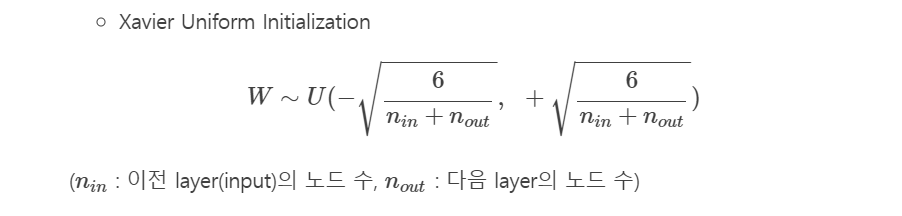


In [9]:
"""
https://jmetzen.github.io/2015-11-27/vae.html
예제4: VAE
참고문헌: Auto-Encoding Variational Bayes - Kingma and Welling (2013)
"""

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

# Load MNIST data in a format suited for tensorflow.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)          # MNIST 데이터에 원핫 인코딩을 적용해서 자료를 로드
n_samples = mnist.train.num_examples                 #mnist의 훈련용 데이터개수를  n_sampes 변수 넣음


#신경망 가중치를 Xavier 방식을이용해 초기화하는 함수
def xavier_init(fan_in, fan_out, constant=1):  
    """ Xavier initialization of neural network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    
    # fan_in , fan_out을 인수로 받아 균등분포로부터의 난수값을 반환
    print(low,"\n\n",high)             #값 확인하기 위해
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)




Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


-0.06835859270246632 

 0.06835859270246632
-0.07745966692414834 

 0.07745966692414834
-0.10741723110591493 

 0.10741723110591493
-0.10741723110591493 

 0.10741723110591493
-0.10741723110591493 

 0.10741723110591493
-0.07745966692414834 

 0.07745966692414834
-0.06835859270246632 

 0.06835859270246632
-0.06835859270246632 

 0.06835859270246632
Epoch: 0001 cost= 175.818494679
Epoch: 0006 cost= 109.054222107
Epoch: 0011 cost= 104.579285112
Epoch: 0016 cost= 102.368889965
Epoch: 0021 cost= 100.834912498
Epoch: 0026 cost= 99.436504808
Epoch: 0031 cost= 98.470509144
Epoch: 0036 cost= 97.764092588
-0.06835859270246632 

 0.06835859270246632
-0.07745966692414834 

 0.07745966692414834
-0.10932607756185055 

 0.10932607756185055
-0.10932607756185055 

 0.10932607756185055
-0.10932607756185055 

 0.10932607756185055
-0.07745966692414834 

 0.07745966692414834
-0.06835859270246632 

 0.06835859270246632
-0.06835859270246632 

 0.06835859270246632
Epoch: 0001 cost= 191.745063393
Epoch: 0006

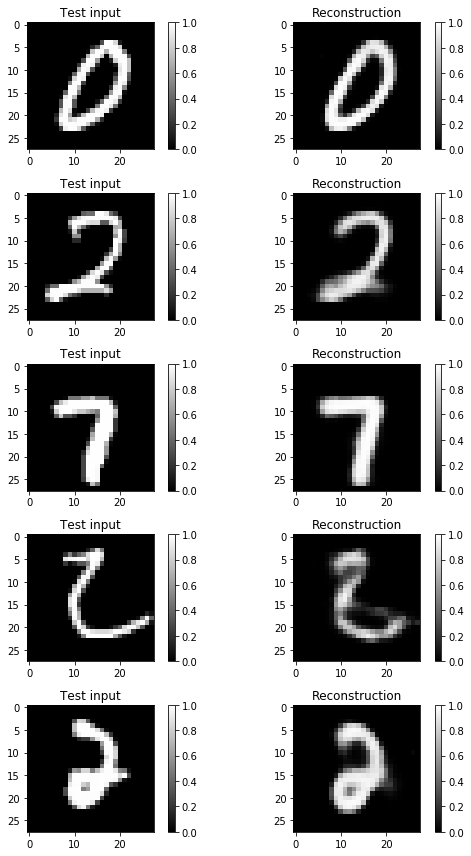

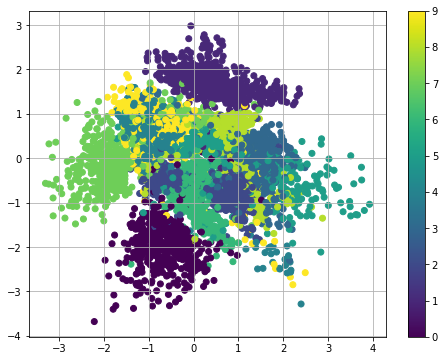

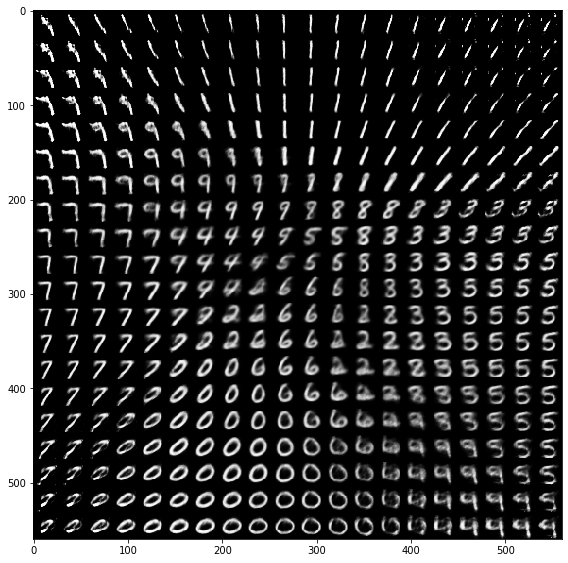

In [10]:
class VAE(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    
    # 변수 초기화, 초기값 할당  함수 
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # 입력 데이터 변수 
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # 오토인코더 신경망을  만듬
        self._create_network()
       
        # Define loss function based variational upper-bound and 
        #  optimizer 만듬
        self._create_loss_optimizer()
        
        # 변수 초기화
        init = tf.global_variables_initializer()

        # 세션 실행
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
     
    #신경망 구성 함수 
    def _create_network(self):
        # 오토 인코드 신경망 weight 와 biases 초기화 
        network_weights = self._initialize_weights(**self.network_architecture)

        # 평균과 (로그) 가우스 분포의 분산 을 결정하기위해  신경망 인식을 사용
        #인코더 신경망 가중치 초기값 선언 
        self.z_mean, self.z_log_sigma_sq = \
            self._encoder_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        #   가우시안 분포로 부터 샘플 n_z를 그림
        n_z = self.network_architecture["n_z"]         #20
        ##평균0 표준편차 1 인 정규분포에의해서 (100,20)의 모양에 랜덤 값 할당
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)     
        
        # z = mu + sigma*epsilon    
        #정규분포 z 
        self.z = tf.add(self.z_mean, tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

     
       
       # 디코더를 통해 나온 결과 값
        self.x_reconstr_mean = \
            self._decoder_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
   


     


    #각 노드의 가중치 할당  (self,500,500,500,500,784,20)                                                           
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),         #(784,500)
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),  #(500,500)
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),         #(500,20)
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}      #(500,20)
        
        #recog 의 bias
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),     #(500)
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),      # (500)
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),         #(20)
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}          #(20)
        
        #generator의 가중치
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),                  #(20,500)
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),       #(500,500)
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),        #(500,784)
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}       #(500,784)
       
        #generator의 bias 
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),         #(500)
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),        #(500)
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),         # (784)
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}           #(784)
        return all_weights
    
    #인코더 신경망 함수 
    def _encoder_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']),     # (self.x * (784, 500) + 500)
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),     #(layer_1 * (500,500) + 500)
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),              #(layer2* (500,20)  +  20 )
                        biases['out_mean'])
        z_log_sigma_sq =tf.add(tf.matmul(layer_2, weights['out_log_sigma']),    biases['out_log_sigma'])               #(layer2 * (500,20) + 20)
                  
        return (z_mean, z_log_sigma_sq)
     
    #디코더 신경망     
    def _decoder_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']),        #(self.z * (20, 500) +500) 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),      #(layer_1 * (500,500) + 500)
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']),       #(layer_2 * (500*784 ) + 784 )
                                 biases['out_mean']))
        return x_reconstr_mean
    
    # optimizer  생성 
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        
        #재구성된 손실- 입력을 재구성하는 역할을 함
        #(인코딩 -> 차원축소-> 디코딩  을 통해 나온 결과 차이)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        
        #잠재적인 손실(정규분포 Z 와 디코더 신경망을 통해 나온 정규분포 차이 )
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        
        # Use 아담 optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
    
    
    # 입력데이터의 미니 배치를 기반으로 모델을 훈련 하여 미니배치의 비용을 반환    
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x: X})
        return cost
    
    #입력된 데이터를 은닉 층으로     x를 입력 받아 정규분포의 평균을 냄
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    #디코더 하기 
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
         # z_mu가 none 아니면 데이터를 생성하고 , none이면 이전데이터를 참고하여 생성
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,       # 인코딩 과정의 정규분포 Z의 평균을 받아 디코더의 결과 출력
                             feed_dict={self.z: z_mu})
    
    # 재구성함수  - 주어진 데이터를 재구성하기 위해 VAE 사용 
   # (입력값으로 x와 z_mu 받아서 나온 결과 비교 위해 만들었을까/)
    def reconstruct(self, X):                                               
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.x: X})

    
    #--------------------------
#We can now define a simple fuction which trains the VAE using mini-batches:        
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VAE(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)        #총 스텝수
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)       #배치 수 만큼 훈련 데이터에서 뽑기

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

#We can now train a VAE on MNIST by just specifying the network topology. 
#We start with training a VAE with a 20-dimensional latent space.
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=36)

#Based on this we can sample some test inputs and visualize 
#how well the VAE can reconstruct those. In general the VAE does really well.
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

#=========== Illustrating latent space ===============#
#Next, we train a VAE with 2d latent space and illustrates 
#how the encoder (the recognition network) encodes some of 
#the labeled inputs (collapsing the Gaussian distribution 
#in latent space to its mean). This gives us some insights into 
#the structure of the learned manifold (latent space)
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=36)

x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

#An other way of getting insights into the latent space is to use 
#the generator network to plot reconstrunctions at the positions 
#in the latent space for which they have been generated:
plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()